# Plot abrupt4xCO2 anomalies and fit different linear responses

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import random as rd
from lmfit import Model
from lmfit.model import save_modelresult, load_modelresult
from scipy import optimize
import importlib
import xarray as xr
from data_loading_functions import *

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
#exp = 'abrupt-4xCO2'
#exp = 'abrupt-2xCO2'
exp = 'abrupt-0p5xCO2'

model_anom_names = [ f.name for f in os.scandir('../../CMIP6-forcing/Processed_data/Global_annual_anomalies/') if f.is_dir() and f.name !='.ipynb_checkpoints']
model_anom_names.sort()

member_dict = {}
for model in model_anom_names:
    anom_exp = [ f.name for f in os.scandir('../../CMIP6-forcing/Processed_data/Global_annual_anomalies/' + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in anom_exp:
        member_dict[model] = find_members(model, exp)
member_dict

{'CESM2': ['r1i1p1f1'],
 'CNRM-CM6-1': ['r1i1p1f2'],
 'CanESM5': ['r1i1p2f1'],
 'GISS-E2-1-G': ['r1i1p1f1'],
 'HadGEM3-GC31-LL': ['r1i1p1f3'],
 'IPSL-CM6A-LR': ['r1i1p1f1'],
 'MIROC6': ['r1i1p1f1'],
 'MRI-ESM2-0': ['r1i1p1f1'],
 'TaiESM1': ['r1i1p1f1']}

## Define linear temperature models

In [3]:
def exp_part1(t, S1, tau1):
    return S1*(1 - np.exp(-t/tau1))
def exp_part2(t, S2, tau2):
    return S2*(1 - np.exp(-t/tau2))
def exp_part3(t, S3, tau3):
    return S3*(1 - np.exp(-t/tau3))
def osc_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part1 + osc_part2

def twoexp_function(t, S1, S2, tau1, tau2):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2)
def threeexp_function(t, S1, S2, S3, tau1, tau2, tau3):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + exp_part3(t, S3, tau3)
def expandosc_function(t, S1, S2, Sosc1, Sosc2, tau1, tau2, taup, Tq):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + osc_parts(t, Sosc1, Sosc2, taup, Tq)

exp_model1 = Model(exp_part1); exp_model2 = Model(exp_part2); 
twoexp_model = Model(twoexp_function);
twoexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
twoexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
twoexp_model.set_param_hint('tau1', value=4, min=0, max=8)
twoexp_model.set_param_hint('tau2', value=20, min=8, max=1000)

exp_model3 = Model(exp_part3); threeexp_model = Model(threeexp_function);
threeexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
threeexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('S3', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('tau1', value=4, min=0, max=8)
threeexp_model.set_param_hint('tau2', value=20, min=8, max=100)
threeexp_model.set_param_hint('tau3', value=200, min=100, max=1000)

osc_model = Model(osc_parts); expandosc_model = Model(expandosc_function)
expandosc_model.set_param_hint('S1', value=4, min=0, max=10.0)# guess the same as for two-box model 
expandosc_model.set_param_hint('S2', value=2, min=0, max=10.0)
expandosc_model.set_param_hint('Sosc1', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('Sosc2', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('tau1', value=4, min=0, max=8)
expandosc_model.set_param_hint('tau2', value=20, min=8, max=1000)


expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
#expandosc_model.set_param_hint('Tq', value=400, min=40, max=2000) # used for longrunmip
expandosc_model.set_param_hint('Tq', value=100, min=40, max=2000)

In [4]:
def modelresult_figure(response_model, model_result, years0, deltaT0, axis = None):
    # takes in response models: 'twoexp', 'threeexp', 'expandosc'
    if axis == None:
        #then create new axis:
        fig, axis = plt.subplots(figsize = [8,6])
        
    axis.set_xlabel('Year',fontsize = 18)
    axis.set_ylabel('T [K]',fontsize = 18)
    axis.set_xlim(min(years0),max(years0))
    axis.tick_params(axis='both',labelsize=18)
    axis.plot(years0, deltaT0, color = 'black')
    
    residuals = model_result.best_fit - model_result.data
    model_rmse = np.sqrt(np.mean(residuals**2))
    #model_rmse = np.sqrt(np.mean(model_result.residual**2))
    axis.plot(years0, model_result.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
    
    # plot components
    axis.plot(years0, exp_model1.eval(model_result.params, t=years0), color = 'lightblue')
    axis.plot(years0, exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
    if response_model == 'twoexp':
        axis.set_title('Two-exponential fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'tau1', 'tau2']
        textlabels = ['$S_1$', '$S_2$', r'$\tau_1$', r'$\tau_2$']
    elif response_model == 'threeexp':
        axis.plot(years0, exp_model3.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Three-exponential fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'S3', 'tau1', 'tau2', 'tau3']
        textlabels = ['$S_1$', '$S_2$', '$S_3$', r'$\tau_1$', r'$\tau_2$', r'$\tau_3$']
    elif response_model == 'expandosc':
        axis.plot(years0, osc_model.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Two-exponential and oscillatory fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
        textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', r'$T_q$']
        
    estimates = [model_result.best_values[par] for par in partoshow]
    axis.text(0.01, 0.95, 'RMSE = ' + str(np.round(model_rmse,3)), transform=axis.transAxes, fontsize = 16)
    axis.text(0.67,0.55, 'Estimates:', fontsize=14, transform=axis.transAxes)
    for (ind, estimate) in enumerate(estimates):
        rounded_estimate = np.round(estimate,2)
        if rounded_estimate == 0:
            axis.text(0.67,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2e}'.format(estimate)), fontsize=14, transform=axis.transAxes)
        else:
            axis.text(0.67,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(rounded_estimate)), fontsize=14, transform=axis.transAxes)
    return axis
    

## 3 different fits for each model

In [5]:
def plot_3fits(years0, deltaT0, model, exp, member, load_results = False, save_results = False, save_figure = False):
    fig, ax = plt.subplots(ncols = 3, figsize = [25,6]);
    fig.suptitle(model + ' ' + member + ' responses to ' + exp, fontsize = 22)
    response_models = ['twoexp', 'threeexp', 'expandosc']
    response_functions = [twoexp_function, threeexp_function, expandosc_function]
    
    rmse_values = []
    for (ax_index, axis) in enumerate(ax):
        response_model = response_models[ax_index]; response_function = response_functions[ax_index]
        
        result_file = '../model_results/' + model + '_' + exp + '_' + member + '_' + response_model + '_results.sav'
        if load_results == True:
            model_result = load_modelresult(result_file, funcdefs = {response_model + '_function': response_function})
            #model_rmse = np.sqrt(np.mean(model_result.residual**2))
            # attribute residual seems to be missing
            # but we can compute it manually from other attributes:
            residuals = model_result.best_fit - model_result.data
            model_rmse = np.sqrt(np.mean(residuals**2))
        else: # obtain new results
            if response_model == 'twoexp':
                model_to_fit = twoexp_model
            elif response_model == 'threeexp':
                model_to_fit = threeexp_model
            elif response_model == 'expandosc':
                model_to_fit = expandosc_model
                 
            model_result = model_to_fit.fit(deltaT0, t=years0)
            model_rmse = np.sqrt(np.mean(model_result.residual**2))
            if response_model == 'expandosc':
                twoexp_rmse = rmse_values[0]
                #if model_rmse > twoexp_rmse: 
                i=0;
                #while model_rmse > twoexp_rmse: # if worse than twoexp, then make new fit
                #    print(i, model, exp)
                #    taup_guess = 10**rd.uniform(np.log10(20), np.log10(1000))
                #    Tq_guess = 10**rd.uniform(np.log10(40), np.log10(2000))
                #    expandosc_model.set_param_hint('taup', value=taup_guess, min=20, max=1000)
                #    expandosc_model.set_param_hint('Tq', value=Tq_guess, min=40, max=2000)
                #    model_result = expandosc_model.fit(deltaT0, t=years0)
                #    model_rmse = np.sqrt(np.mean(model_result.residual**2))
                #    i += 1; 
                # reset par hints:
                #expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
                #expandosc_model.set_param_hint('Tq', value=100, min=40, max=2000)
        if save_results == True:
             save_modelresult(model_result, result_file) 
        
        modelresult_figure(response_model, model_result, years0, deltaT0, axis = axis)
        rmse_values.append(model_rmse)
    if save_figure == True:
        plt.savefig('../Figures/CMIP6_modelcomparisons/' + model + '_' + member + '_' + exp + '_linresponses_comparison.pdf', format='pdf', dpi=600, bbox_inches="tight")
    
    return rmse_values
        

CESM2


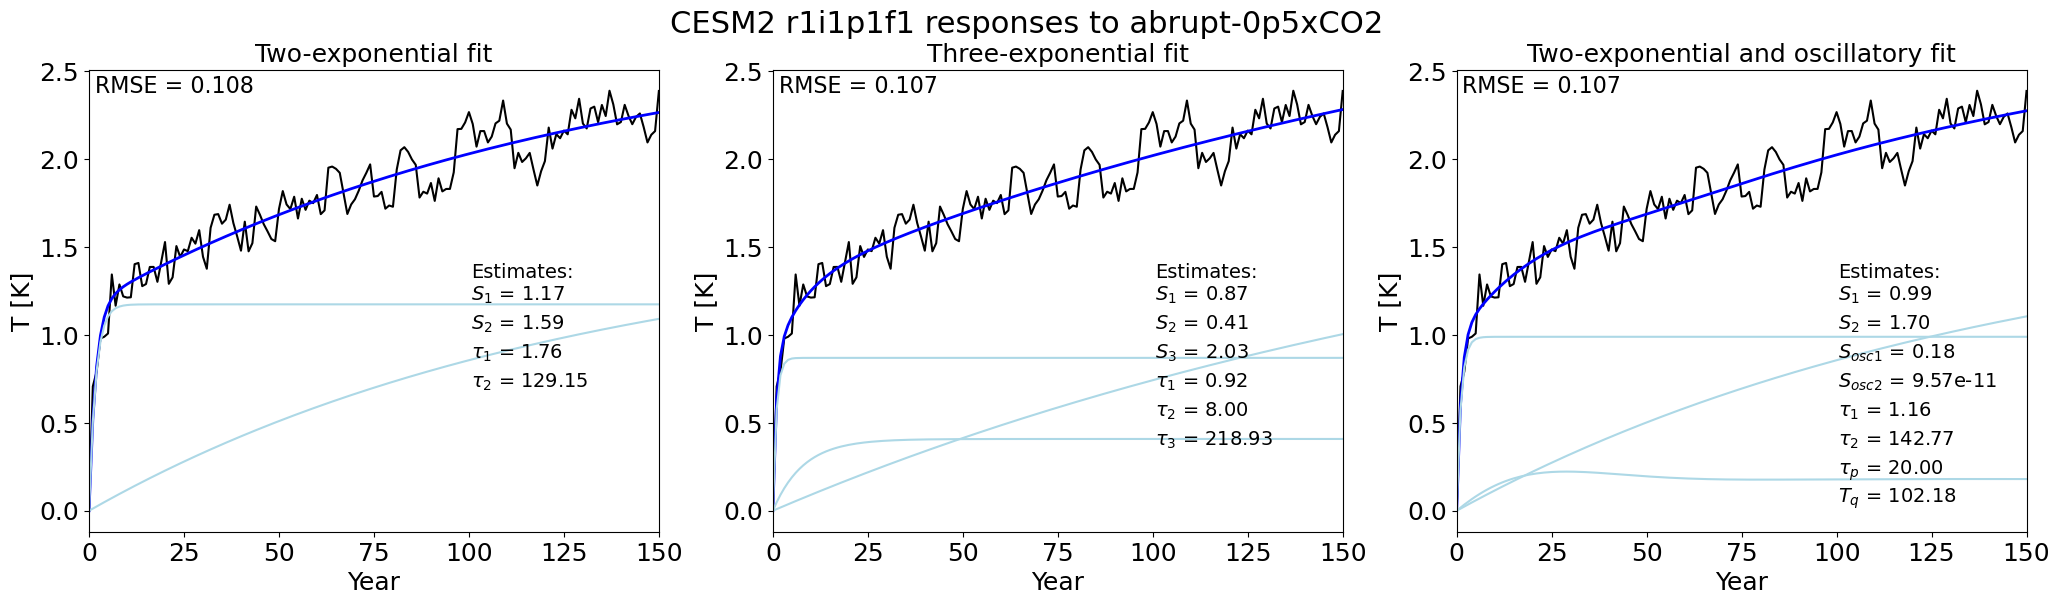

CNRM-CM6-1


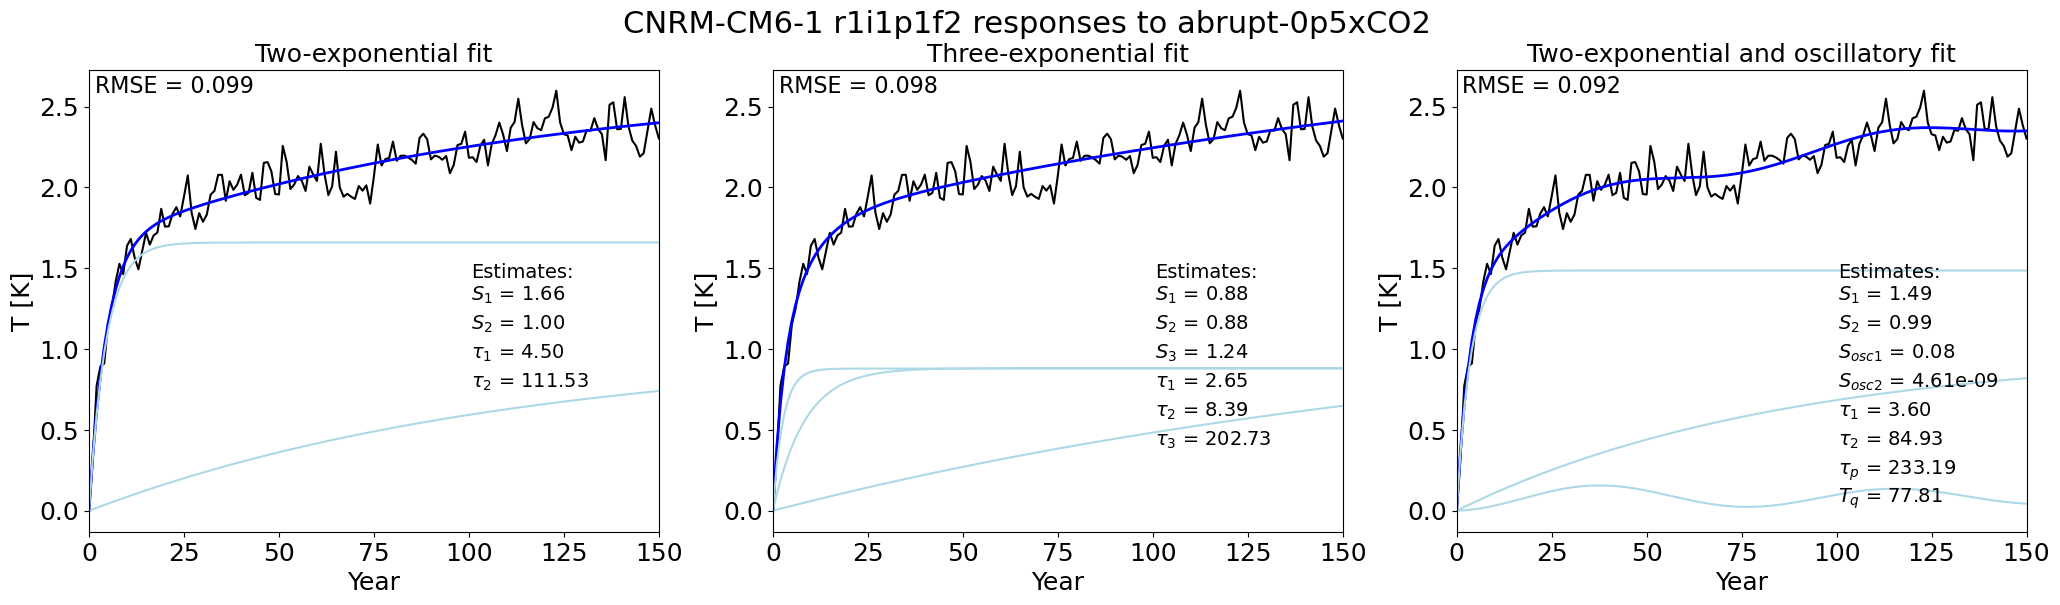

CanESM5


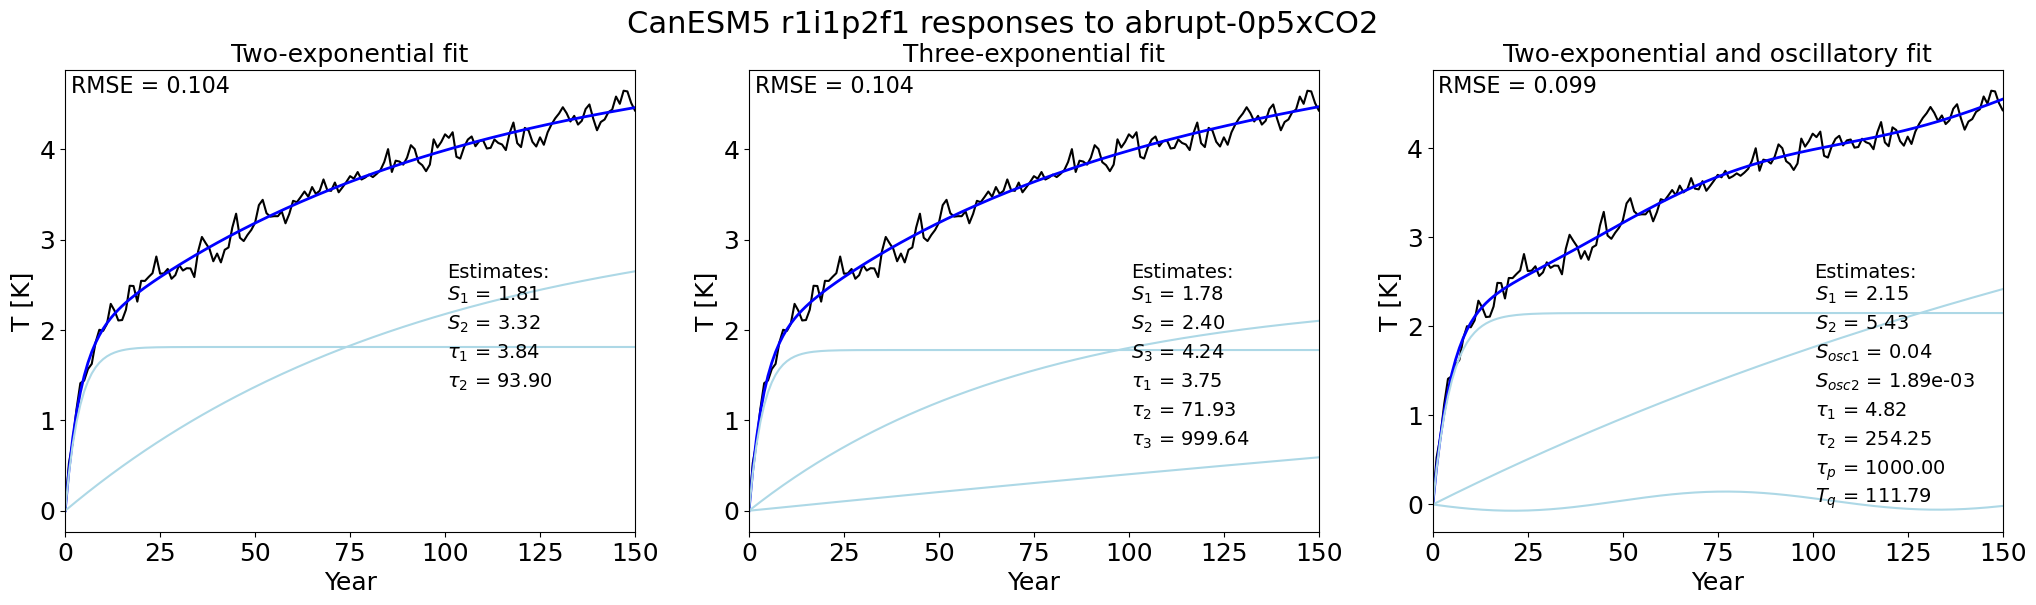

GISS-E2-1-G


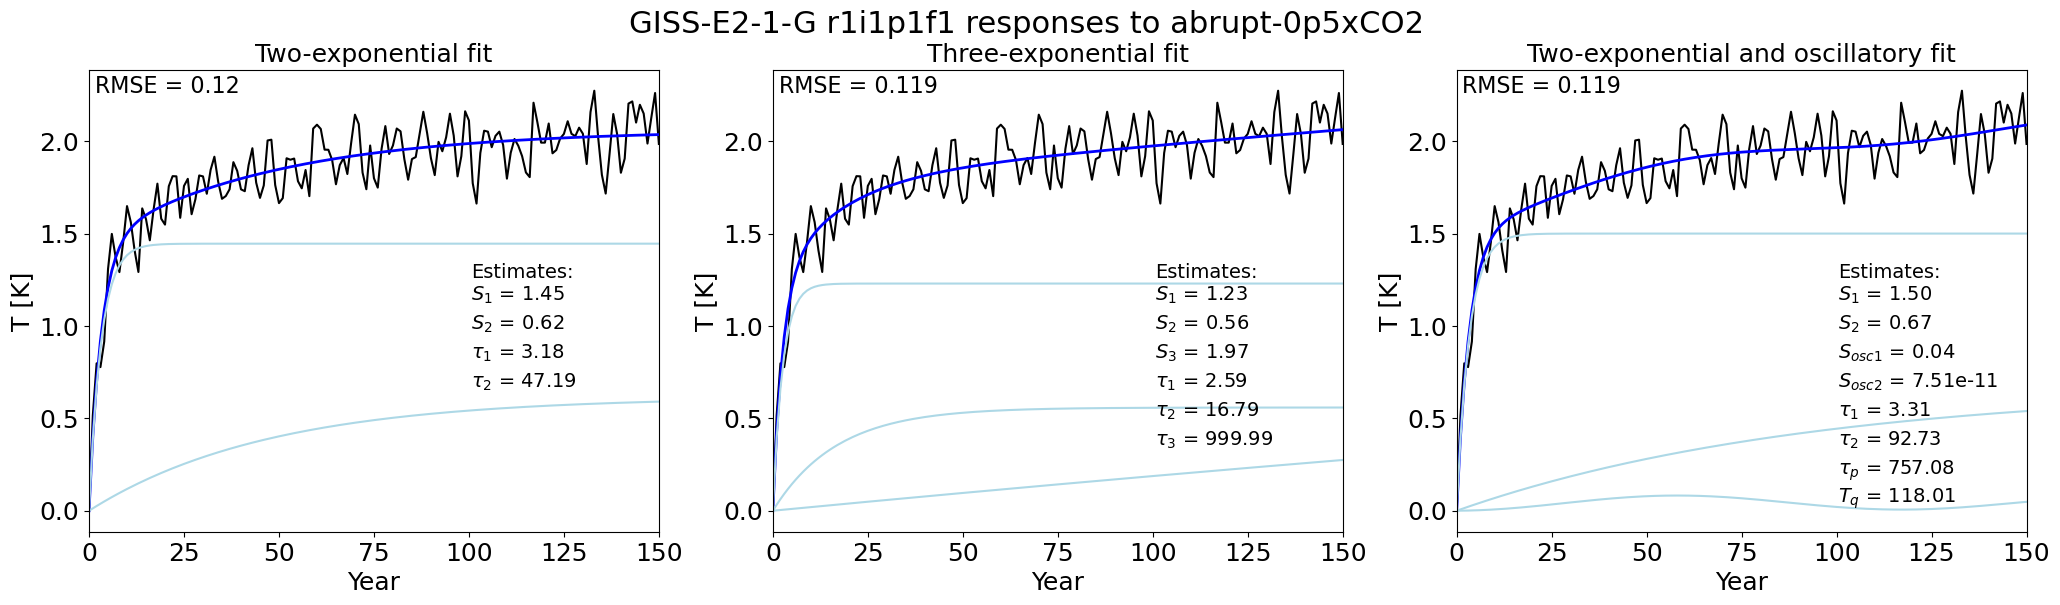

HadGEM3-GC31-LL


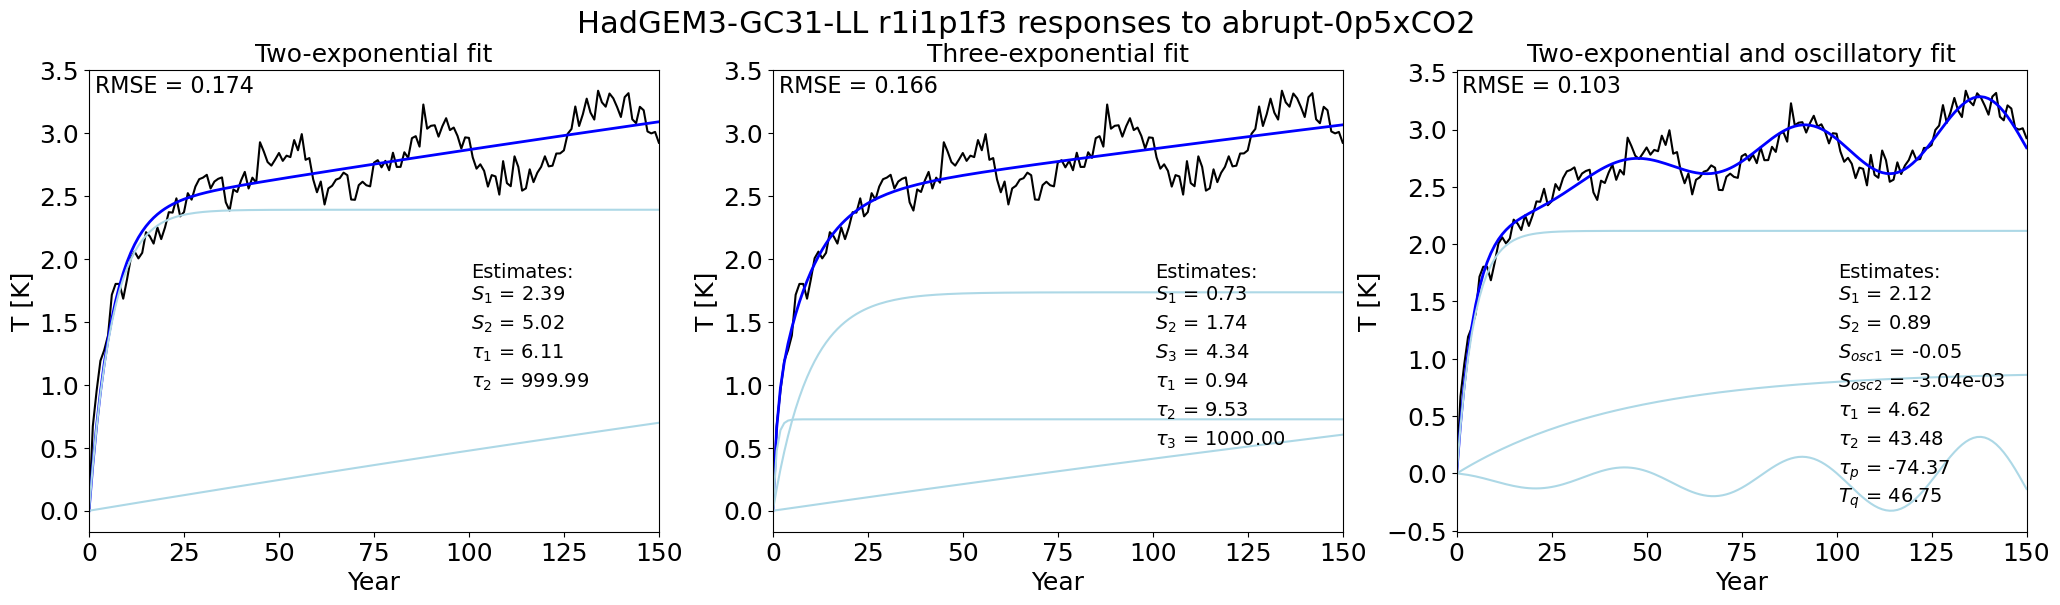

IPSL-CM6A-LR


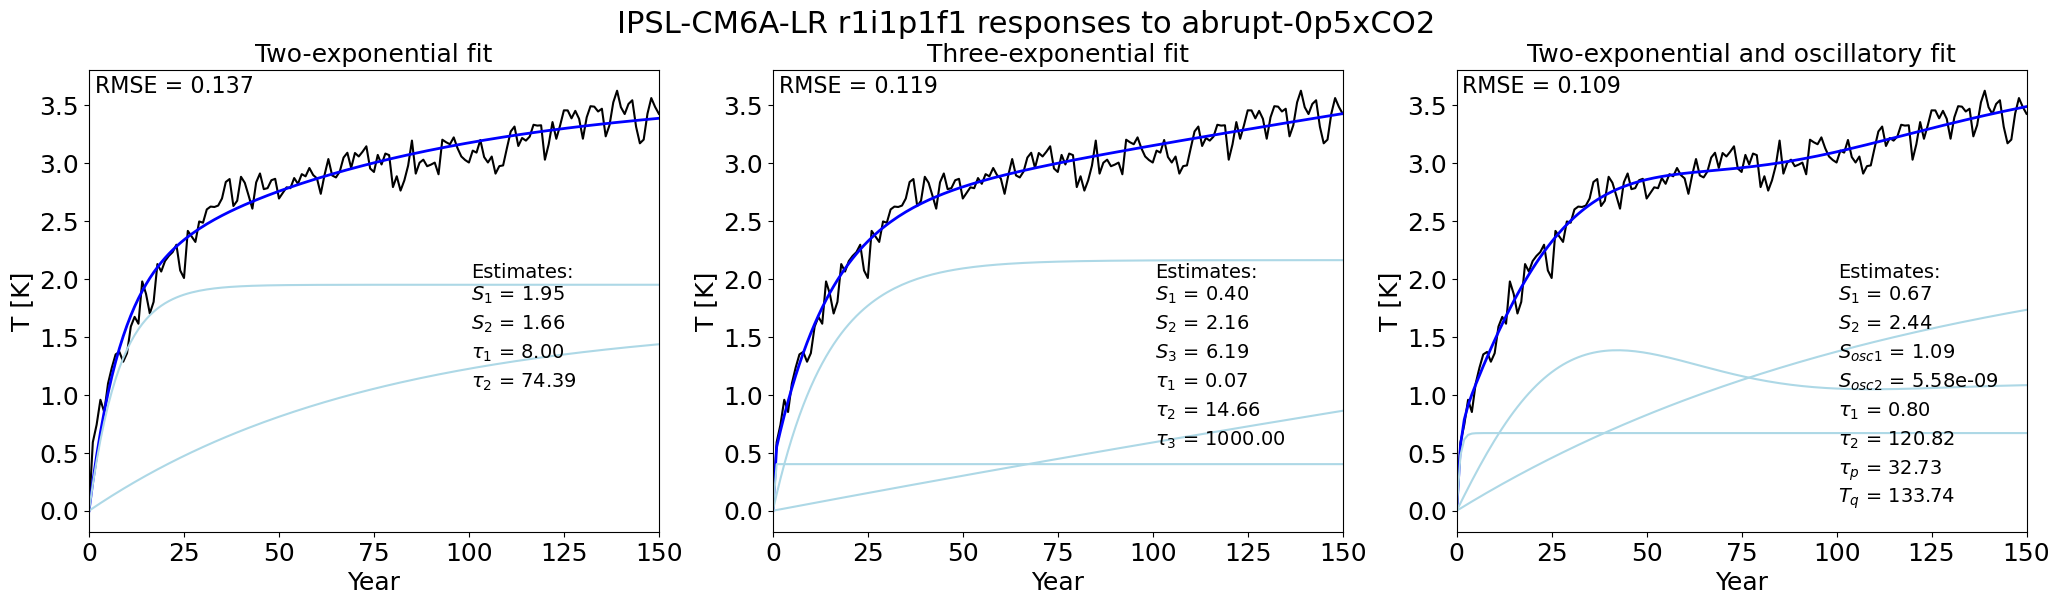

MIROC6


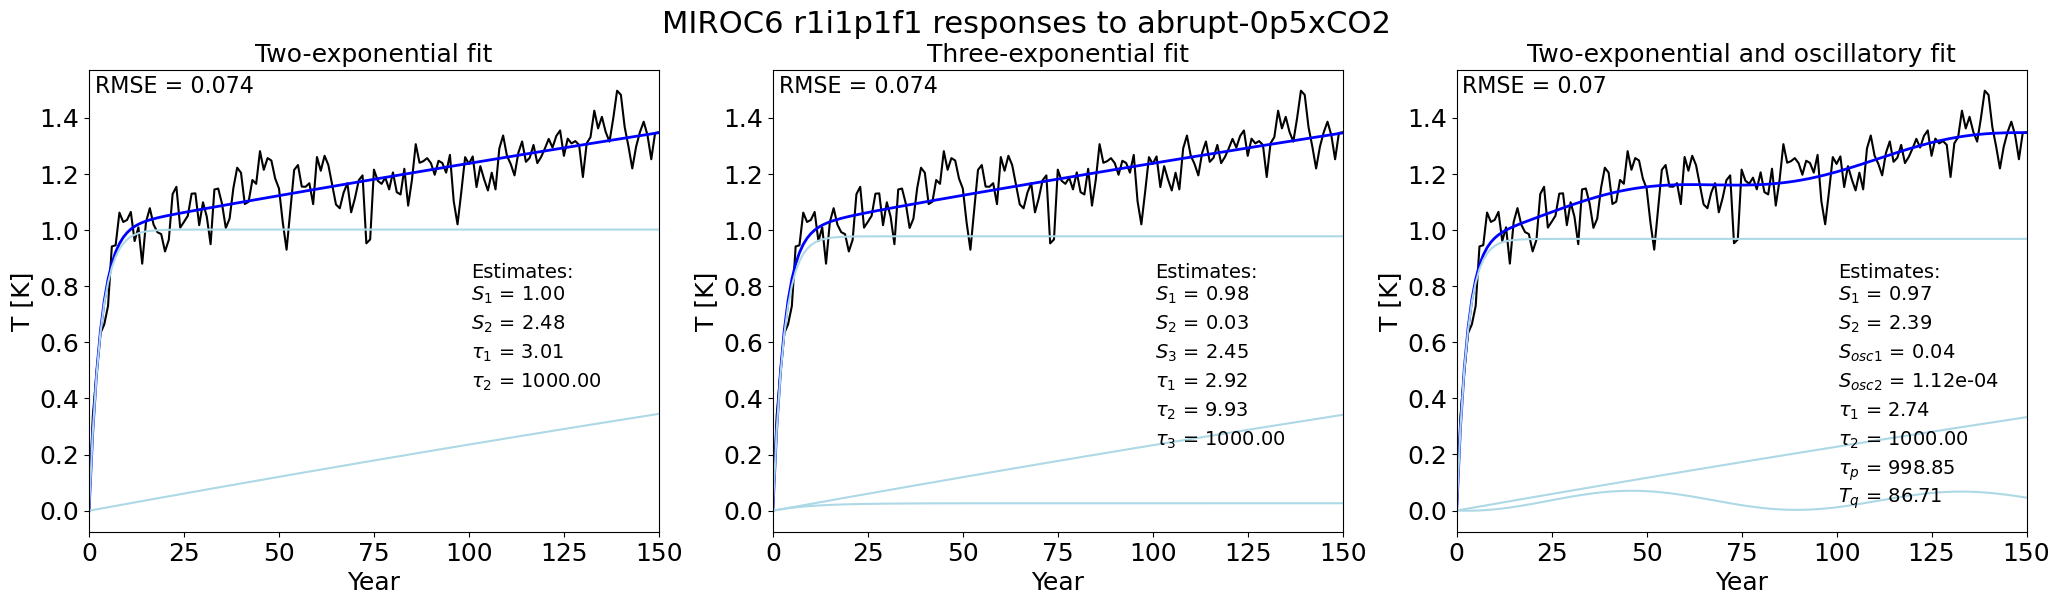

MRI-ESM2-0


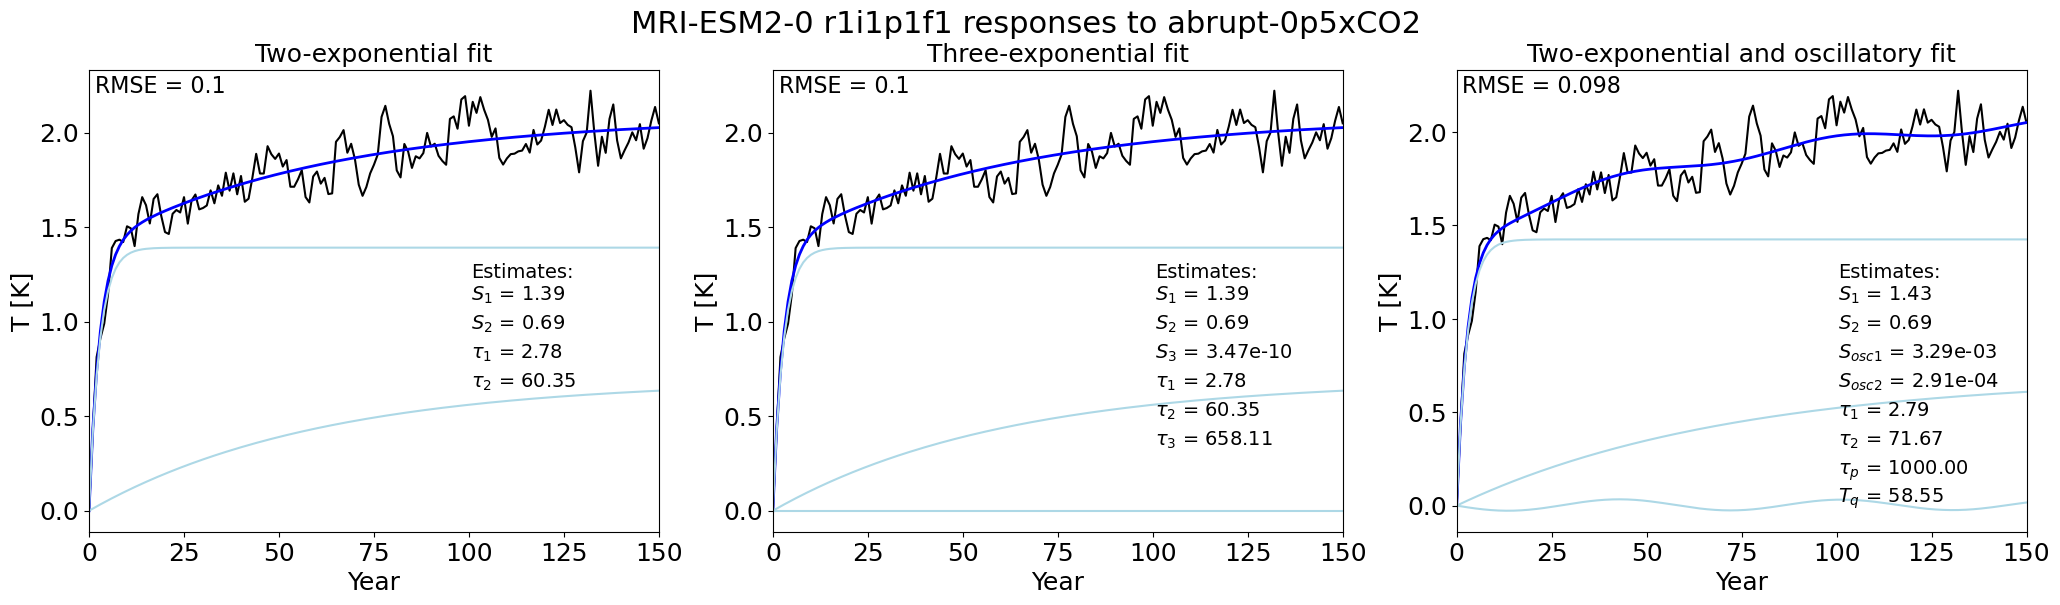

TaiESM1


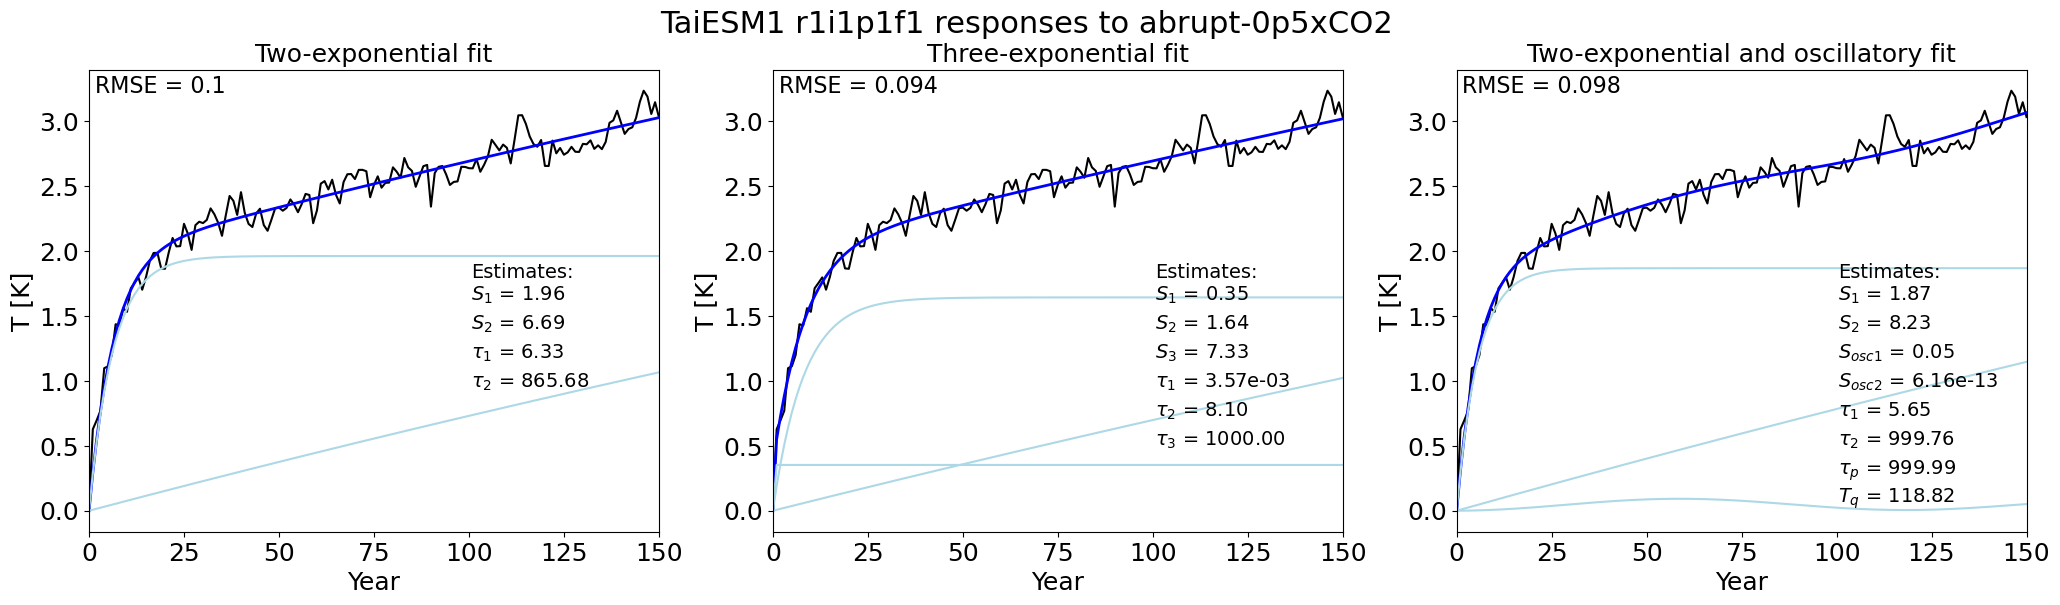

{'CESM2': {'r1i1p1f1': [0.10790462157977485,
   0.10657532158239666,
   0.10655965146013219]},
 'CNRM-CM6-1': {'r1i1p1f2': [0.09910799952193994,
   0.09810408289999117,
   0.09190975232846826]},
 'CanESM5': {'r1i1p2f1': [0.1038128988523708,
   0.10372510674720832,
   0.09871657328521269]},
 'GISS-E2-1-G': {'r1i1p1f1': [0.12023292268906532,
   0.11930083232886718,
   0.11922113773737743]},
 'HadGEM3-GC31-LL': {'r1i1p1f3': [0.17414841113769364,
   0.16565004243089718,
   0.102920903996514]},
 'IPSL-CM6A-LR': {'r1i1p1f1': [0.1371039017992304,
   0.1186772368585628,
   0.10920553078326406]},
 'MIROC6': {'r1i1p1f1': [0.07378039565532181,
   0.07377133502193685,
   0.07041735603983713]},
 'MRI-ESM2-0': {'r1i1p1f1': [0.09958705636276714,
   0.09958705632954322,
   0.09782766206716069]},
 'TaiESM1': {'r1i1p1f1': [0.09972827451765329,
   0.09434562689576254,
   0.0976068712151867]}}

In [8]:
rmse_list = []; rmse_dict = {}
#for model in ['ACCESS-CM2']:
#for model in ['MRI-ESM2-0']:
#for model in ['HadGEM3-GC31-LL']:
for model in member_dict:
    rmse_dict[model] = {}
    print(model)
    for member in member_dict[model]:
        data = load_anom(model, exp, member, length_restriction = 150)
        deltaN = data['rsdt'] - data['rsut'] - data['rlut']
        deltaT = data['tas']; years = np.arange(1,150+1)
        if len(deltaT)<150:
            continue
        deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))
        if exp == 'abrupt-0p5xCO2':
            deltaT0 *= -1 # flip signs
            if model == 'HadGEM3-GC31-LL':
                # guess shorter period
                expandosc_model.set_param_hint('Sosc1', value=0.01, min=-0.05, max=0.1)
                expandosc_model.set_param_hint('Sosc2', value=0.01, min=-0.05, max=0.1)
                expandosc_model.set_param_hint('Tq', value=45, min=20, max=60)
                expandosc_model.set_param_hint('taup', value=-85, min=-1000, max=-1)
                

        #plot_3fits(years0, deltaT0, model, exp, member)
        #rmse_values = plot_3fits(years0, deltaT0, model, exp, member, load_results = False, save_results = True)
        rmse_values = plot_3fits(years0, deltaT0, model, exp, member, load_results = True, save_figure = False)
        rmse_dict[model][member] = rmse_values
        rmse_values = [model, exp, member] + rmse_values
        rmse_list.append(rmse_values)
        plt.show()
        
rmse_dict


In [9]:
rmse_df = pd.DataFrame(rmse_list, columns=['model', 'exp', 'member', 'RMSE two-exp', 'RMSE three-exp', 'RMSE two-exp + osc'])
rmse_df;


In [10]:
pct_diff1 = pd.DataFrame((rmse_df['RMSE three-exp'] - rmse_df['RMSE two-exp'])/rmse_df['RMSE two-exp']*100, columns = ['% change1']) # percent change
pct_diff2 = pd.DataFrame((rmse_df['RMSE two-exp + osc'] - rmse_df['RMSE three-exp'])/rmse_df['RMSE three-exp']*100, columns = ['% change2']) # percent change

rmse_table = rmse_df.join([np.round(pct_diff1,3), np.round(pct_diff2,3)])
pd.set_option('display.max_rows', None)

# make model the index
rmse_table2 = pd.DataFrame(rmse_table.values[:,2:], columns = rmse_table.columns[2:], index = rmse_table['model'])
rmse_table2



member RMSE two-exp RMSE three-exp RMSE two-exp + osc  \
model                                                                      
CESM2            r1i1p1f1     0.107905       0.106575            0.10656   
CNRM-CM6-1       r1i1p1f2     0.099108       0.098104            0.09191   
CanESM5          r1i1p2f1     0.103813       0.103725           0.098717   
GISS-E2-1-G      r1i1p1f1     0.120233       0.119301           0.119221   
HadGEM3-GC31-LL  r1i1p1f3     0.174148        0.16565           0.102921   
IPSL-CM6A-LR     r1i1p1f1     0.137104       0.118677           0.109206   
MIROC6           r1i1p1f1      0.07378       0.073771           0.070417   
MRI-ESM2-0       r1i1p1f1     0.099587       0.099587           0.097828   
TaiESM1          r1i1p1f1     0.099728       0.094346           0.097607   

                % change1 % change2  
model                                
CESM2              -1.232    -0.015  
CNRM-CM6-1         -1.013    -6.314  
CanESM5            -0.085    -4.829  
GISS-E2-1-G        -0.775    -0.067  
HadGEM3-GC31-LL     -4.88   -37.868  
IPSL-CM6A-LR       -13.44    -7.981  
MIROC6             -0.012    -4.546  
MRI-ESM2-0           -0.0    -1.767  
TaiESM1            -5.397     3.457

In [11]:
#rmse_table2.to_csv('../cmip6_abrupt-4xCO2_rmse_table.csv')
#rmse_table2.to_csv('../cmip6_abrupt-2xCO2_rmse_table.csv')
#rmse_table2.to_csv('../cmip6_abrupt-0p5xCO2_rmse_table.csv')

In [10]:
s = rmse_table2.style.format(precision=3)
s.set_table_styles([
        {'selector': 'toprule', 'props': ':hline;'},
        {'selector': 'midrule', 'props': ':hline;'},
        {'selector': 'bottomrule', 'props': ':hline;'}]);
print(s.to_latex(column_format= 'lcccccc'))

\begin{tabular}{lcccccc}
\hline
 & member & RMSE two-exp & RMSE three-exp & RMSE two-exp + osc & % change1 & % change2 \\
model &  &  &  &  &  &  \\
\hline
CESM2 & r1i1p1f1 & 0.096 & 0.096 & 0.096 & 0.000 & -0.029 \\
CNRM-CM6-1 & r1i1p1f2 & 0.106 & 0.106 & 0.104 & -0.046 & -1.814 \\
CanESM5 & r1i1p2f1 & 0.117 & 0.115 & 0.113 & -1.786 & -1.919 \\
GISS-E2-1-G & r102i1p1f1 & 0.144 & 0.144 & 0.143 & 0.000 & -0.376 \\
GISS-E2-1-G & r1i1p1f1 & 0.140 & 0.140 & 0.136 & 0.000 & -3.105 \\
GISS-E2-1-G & r1i1p3f1 & 0.164 & 0.158 & 0.153 & -3.483 & -3.061 \\
GISS-E2-1-G & r1i1p5f1 & 0.180 & 0.180 & 0.179 & -0.167 & -0.606 \\
GISS-E2-1-H & r1i1p1f1 & 0.121 & 0.120 & 0.119 & -0.310 & -0.914 \\
GISS-E2-1-H & r1i1p5f1 & 0.143 & 0.139 & 0.139 & -2.329 & 0.022 \\
GISS-E2-2-G & r1i1p1f1 & 0.116 & 0.116 & 0.112 & -0.219 & -3.268 \\
GISS-E2-2-H & r1i1p1f1 & 0.085 & 0.081 & 0.080 & -4.737 & -1.617 \\
HadGEM3-GC31-LL & r1i1p1f3 & 0.094 & 0.094 & 0.094 & -0.000 & -0.095 \\
IPSL-CM6A-LR & r1i1p1f1 & 0.132 & 0.1

In [12]:
np.sum(pct_diff2<0)

c:\Users\hege.fredriksen\.conda\envs\general_analyses\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


% change2    8
dtype: int64

In [13]:
len(pct_diff2)

9

In [13]:
np.sum(pct_diff2>0)

% change2    2
dtype: int64

## Combine all abrupt-4xCO2 fits with RMSE improvement of more than 3%

In [56]:
amoc_df = pd.read_table('../cmip6_abrupt-4xCO2_amoc_table.csv', sep=',')
rmse_df = pd.read_table('../cmip6_abrupt-4xCO2_rmse_table.csv', sep=',')
all_joined = pd.merge(rmse_df, amoc_df, on=['model', 'member'], how='outer')
all_above3perc = all_joined[all_joined['% change2'] < -3]

matching_rows = pd.merge(amoc_df, rmse_df, on=['model', 'member'], how='inner')
matching_above3perc = matching_rows[matching_rows['% change2'] < -3]

In [32]:
len(all_above3perc)

26

In [57]:
datadir = '../../Other_data/AMOC_CMIP6/'
file_list = [ f.name for f in os.scandir(datadir) if f.is_file()]
# set water density
h2o_rho = 1035 # kg/m**3

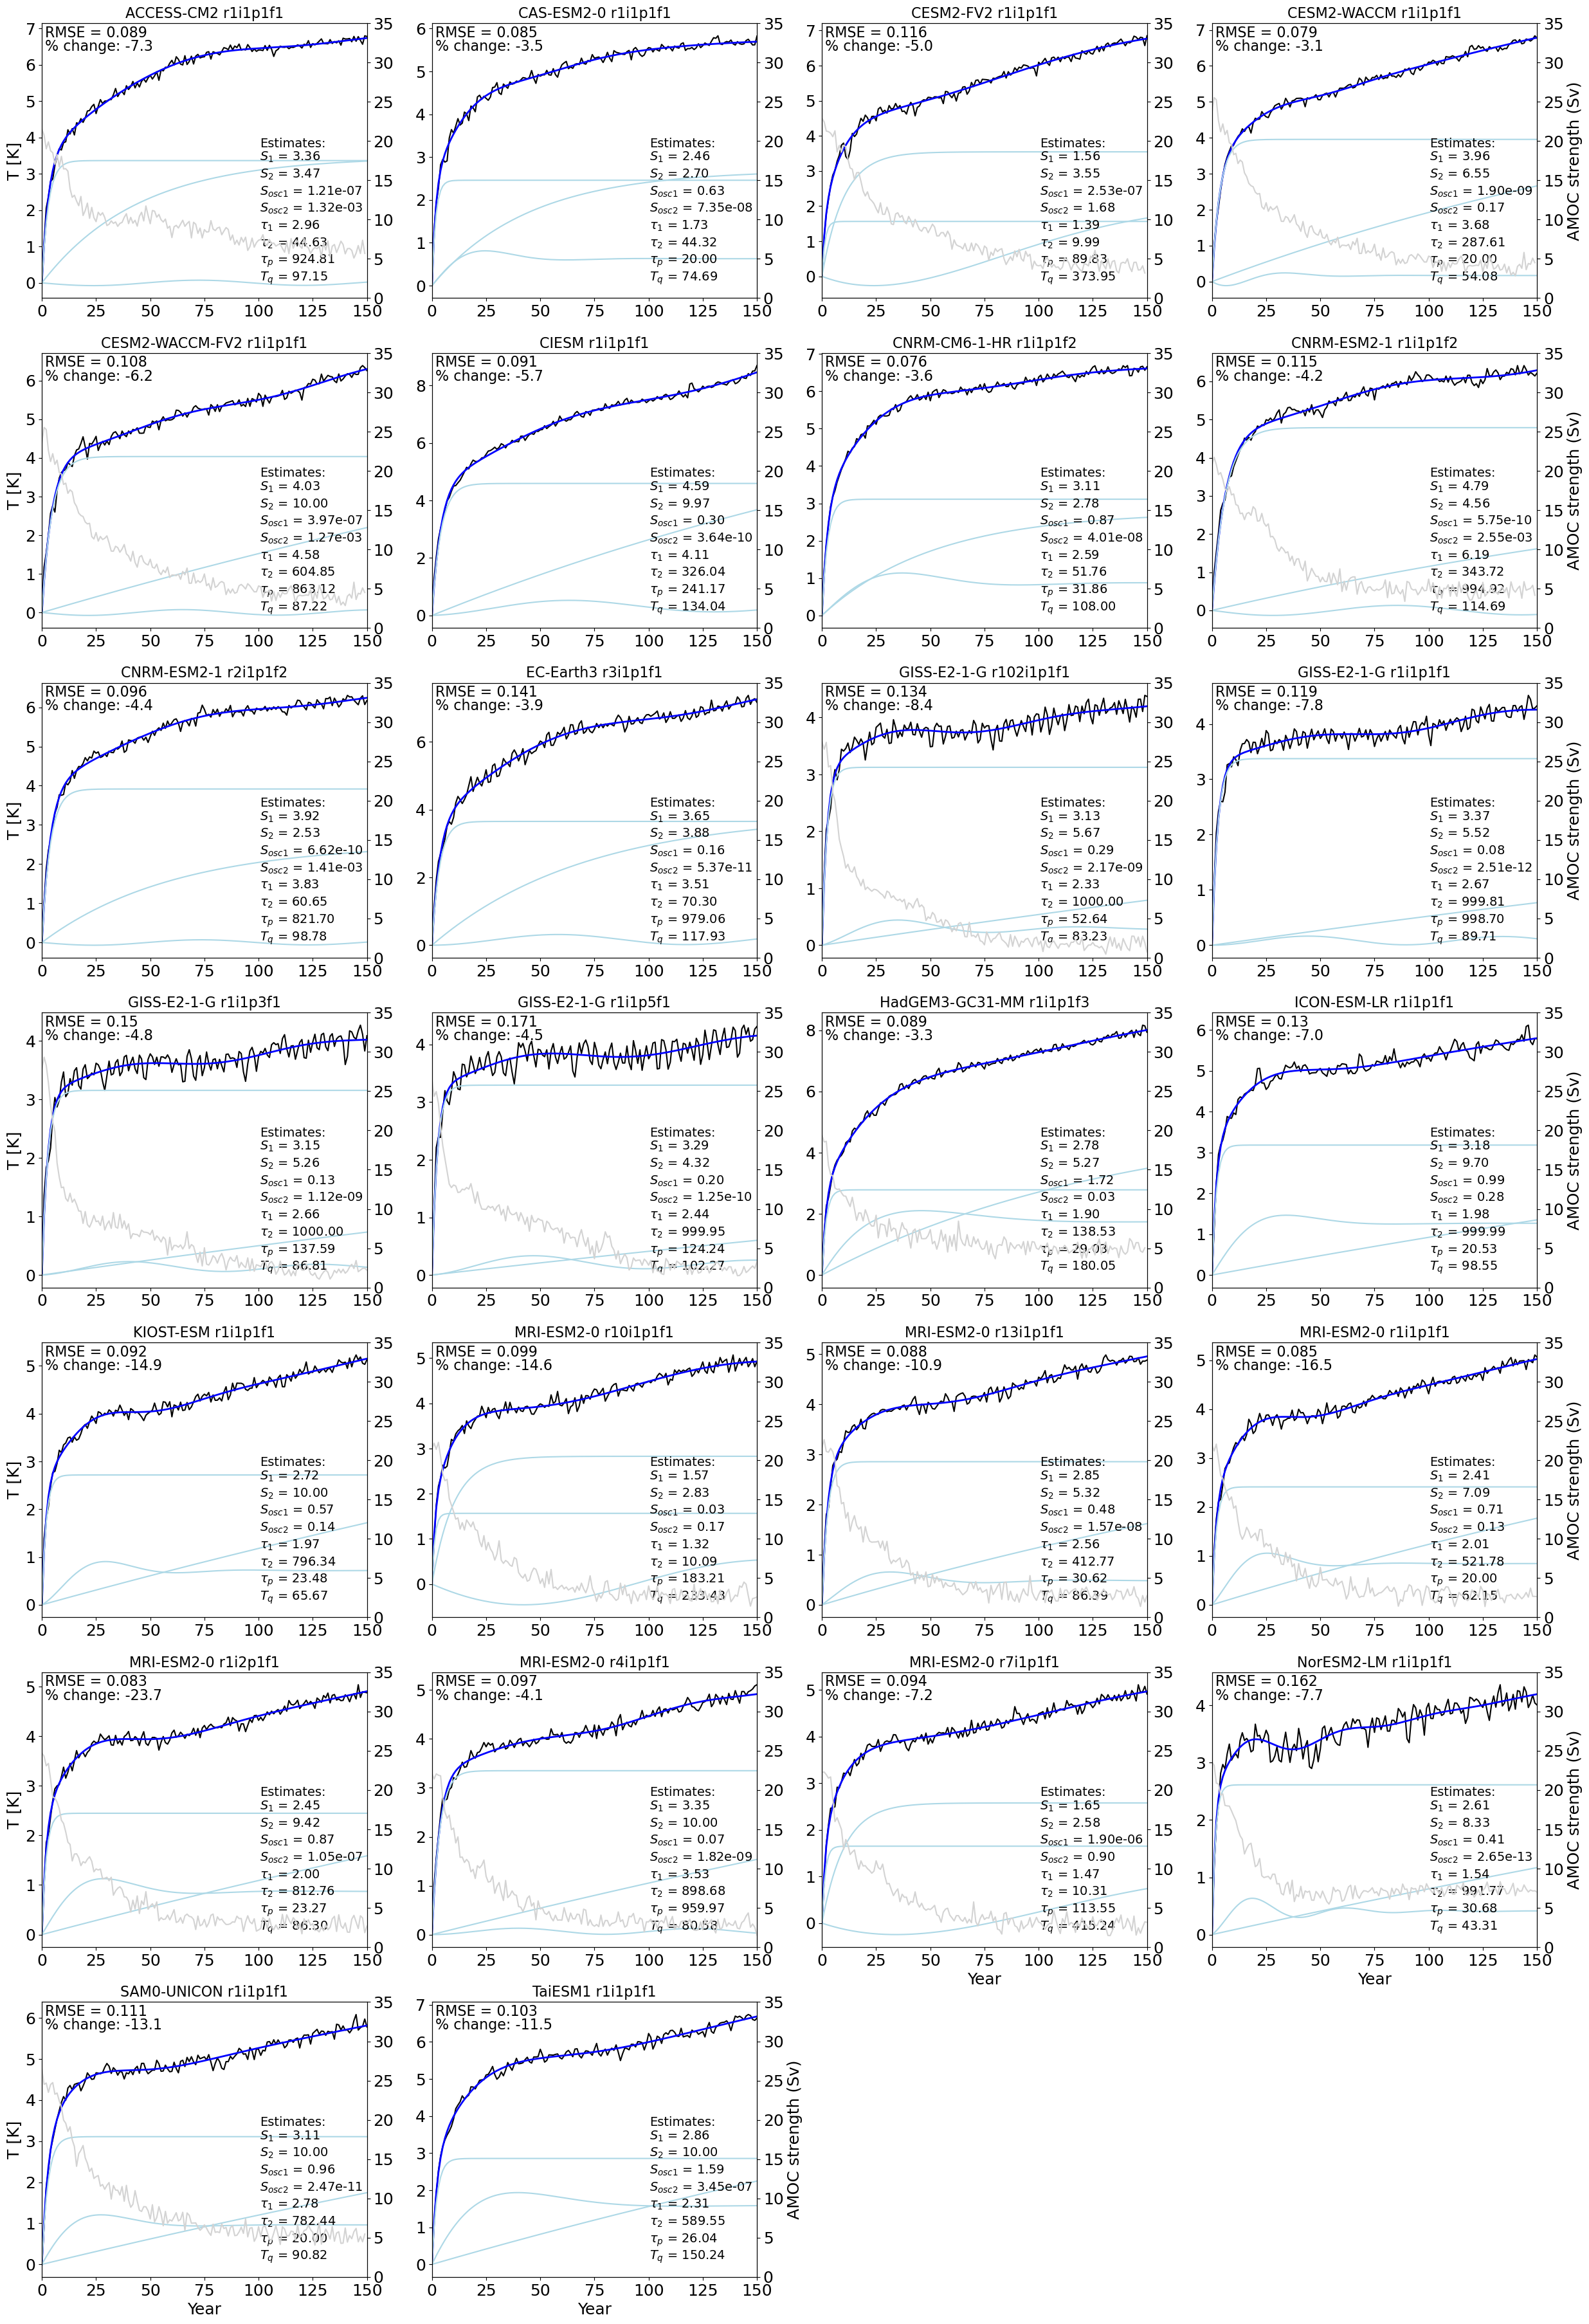

In [ ]:
fig, axes = plt.subplots(nrows = 7, ncols = 4, figsize = [30,26*7/4])
ax = np.concatenate(axes)
exp = 'abrupt-4xCO2'

for k in range(len(all_above3perc)):
    df_row = all_above3perc.iloc[k]
    model = df_row['model']
    member = df_row['member']

    data = load_anom(model, exp, member, length_restriction = 150)
    deltaN = data['rsdt'] - data['rsut'] - data['rlut']
    deltaT = data['tas']; years = np.arange(1,150+1)
    if len(deltaT)<150:
        continue
    deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))
    result_file = '../model_results/' + model + '_' + exp + '_' + member + '_expandosc_results.sav'
    model_result = load_modelresult(result_file, funcdefs = {'expandosc_function': expandosc_function})
    ax[k] = modelresult_figure('expandosc', model_result, years0, deltaT0, axis = ax[k])

    # add amoc plot in same panel if data are available:
    amocax = ax[k].twinx()
    model_files = [file for file in file_list if model in file]
    if len(model_files) != 0:
        member_file = [file for file in model_files if member in file]
        if len(member_file) != 0:
            
            model_ds = xr.load_dataset(datadir + member_file[0])
            (model_ds.amoc_a4x/h2o_rho/10**6).plot(ax=amocax, color = 'lightgray')
    amocax.tick_params(axis='both',labelsize=18)
    amocax.set_ylabel('AMOC strength (Sv)', fontsize = 18);
    amocax.set_ylim(0,35)


    ax[k].set_title(model + ' ' + member, fontsize = 16)
    #ax[k].set_title(model + ' ' + exp + ' ' + member, fontsize = 16)
    rmse_change = 100*(rmse_dict[model][member][2] - rmse_dict[model][member][1])/rmse_dict[model][member][1]
    ax[k].text(0.01, 0.9, '% change: ' + str(np.round(rmse_change,1)), transform=ax[k].transAxes, fontsize = 16)
    if k<22:
        ax[k].set_xlabel('')
    if (k+1) % 4 != 0:
        if k != 25:
            amocax.set_ylabel('')    
    if k % 4 != 0:
        ax[k].set_ylabel('') 

fig.delaxes(ax[-1]); fig.delaxes(ax[-2]);
        
#plt.savefig('../' + exp + '_26expandosc_results.pdf', format='pdf', dpi=600, bbox_inches="tight")        


## Plot all abrupt-2xCO2 fits

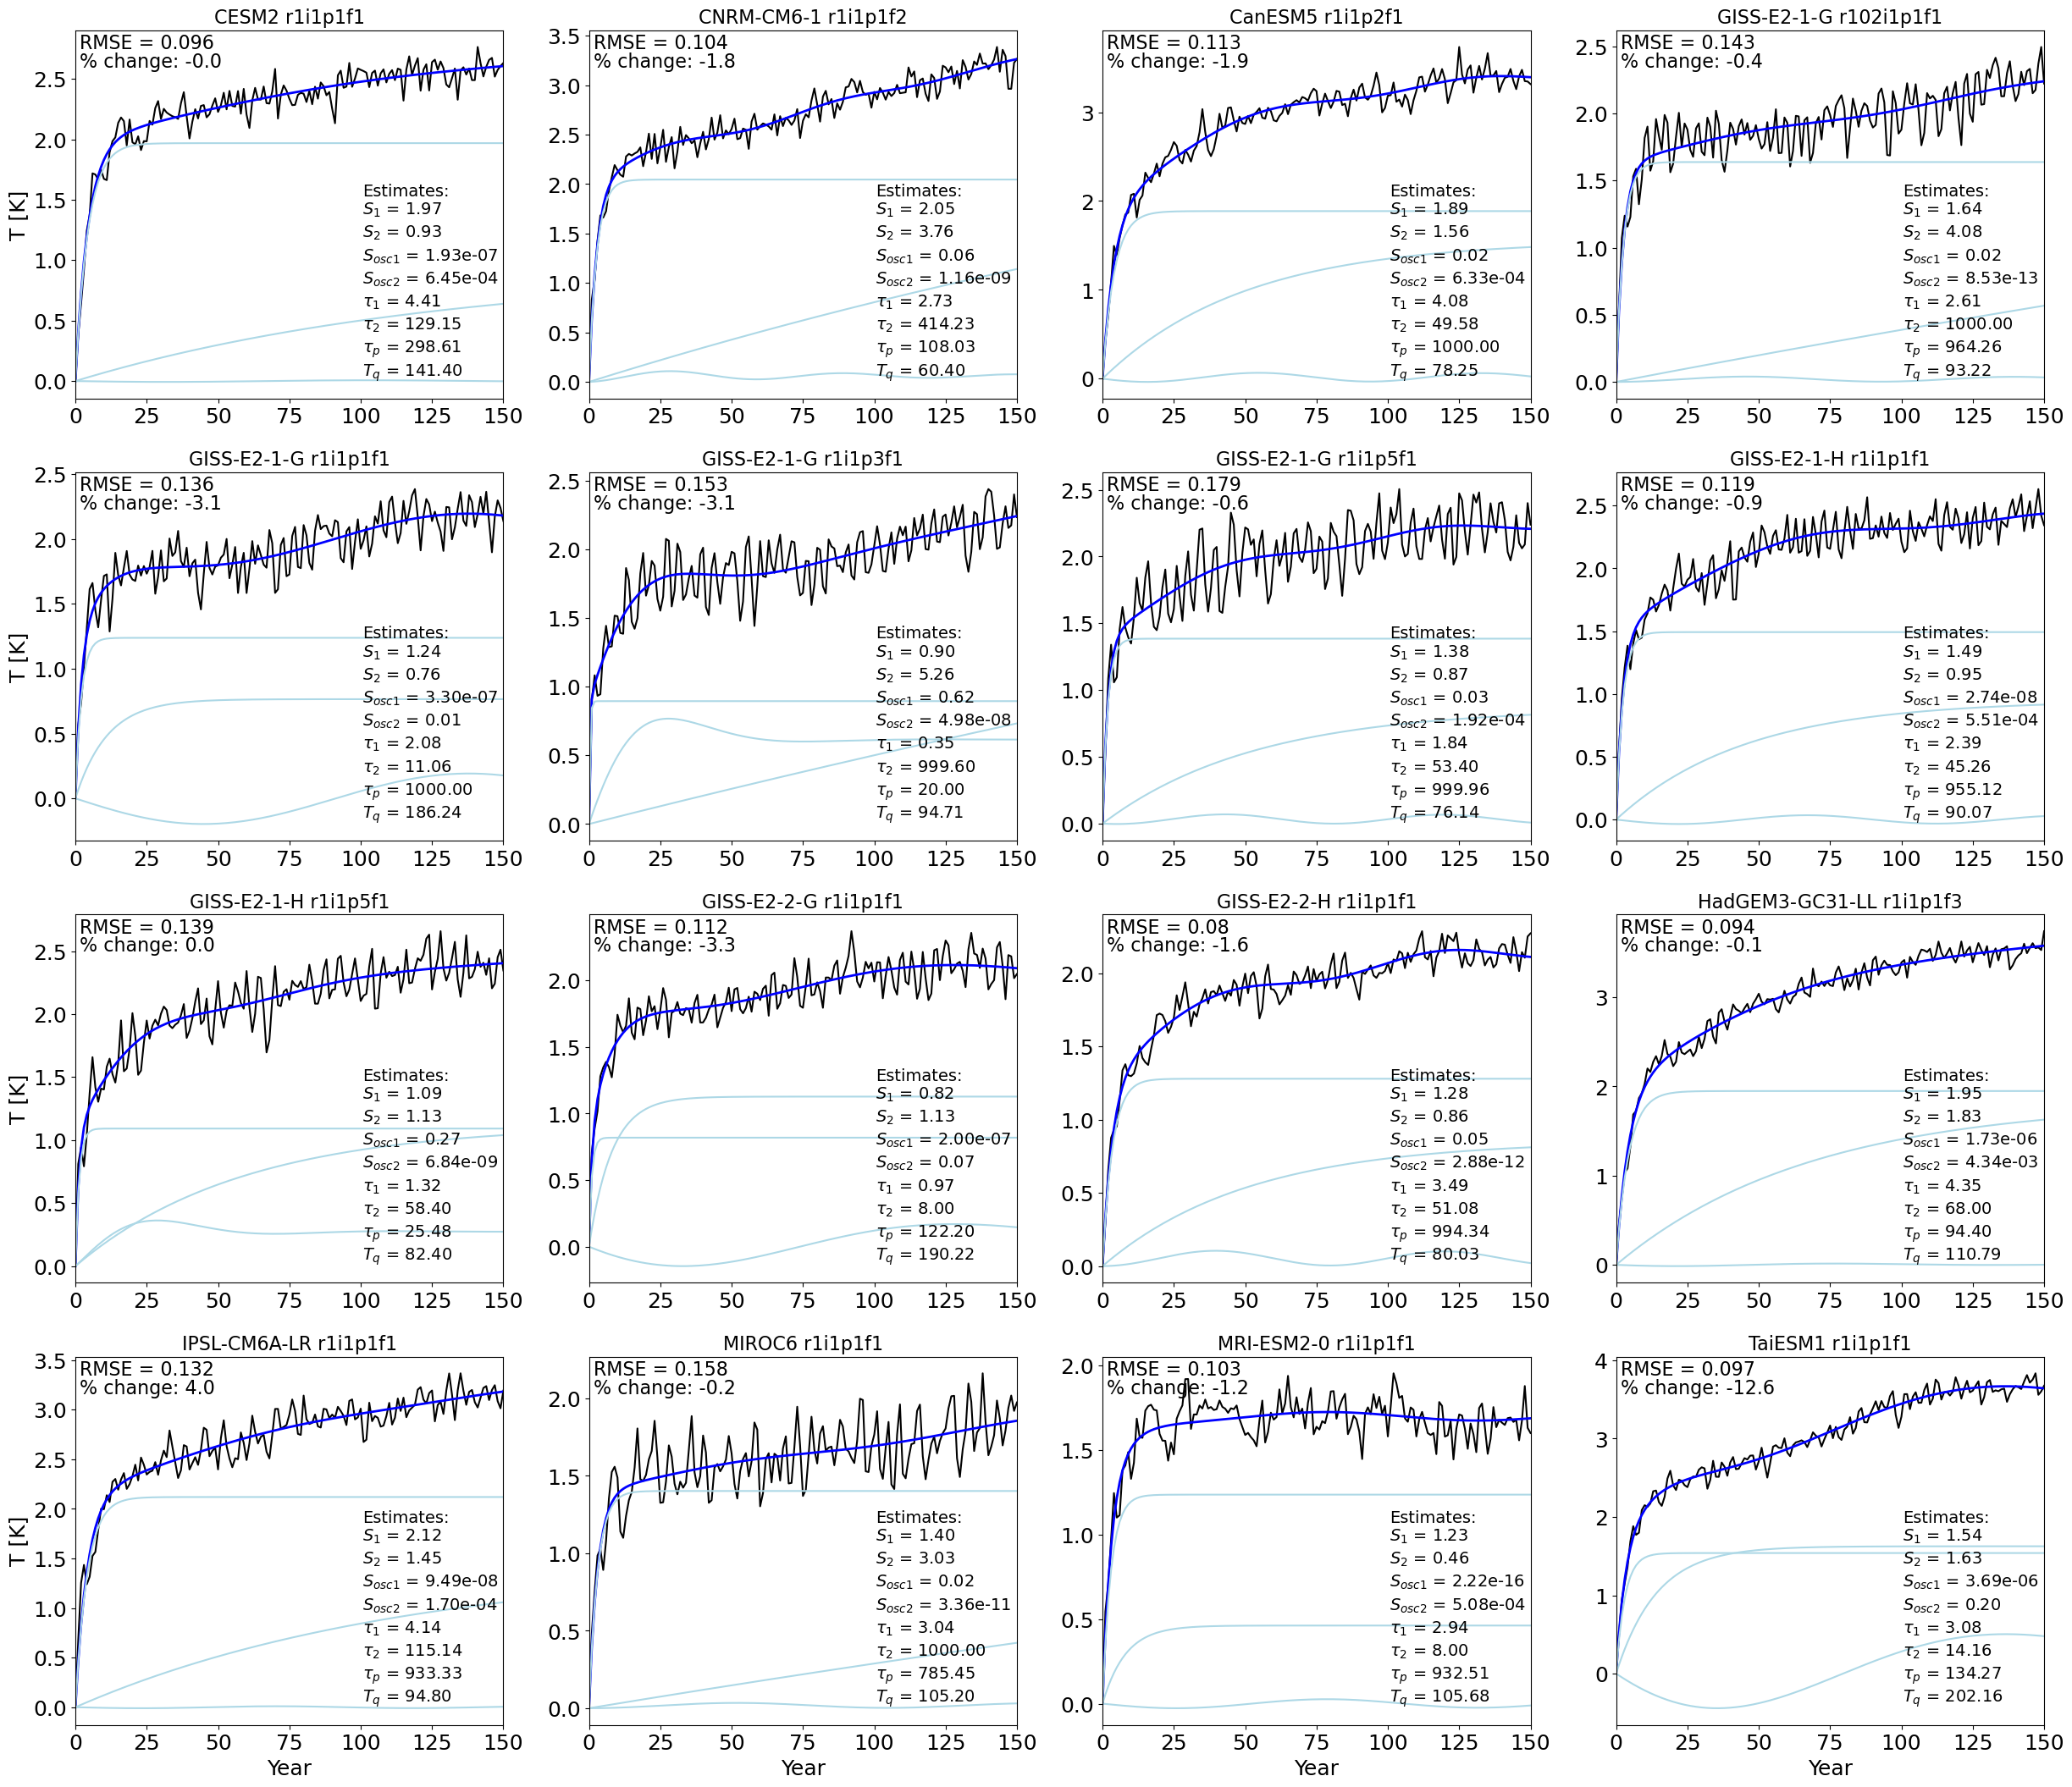

In [48]:
rmse_df = pd.read_table('../cmip6_abrupt-2xCO2_rmse_table.csv', sep=',').reset_index()

fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = [30,26])
ax = np.concatenate(axes)
exp = 'abrupt-2xCO2'

for k in range(len(rmse_df)):
    df_row = rmse_df.iloc[k]
    model = df_row['model']
    member = df_row['member']

    data = load_anom(model, exp, member, length_restriction = 150)
    deltaN = data['rsdt'] - data['rsut'] - data['rlut']
    deltaT = data['tas']; years = np.arange(1,150+1)
    if len(deltaT)<150:
        continue
    deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))
    result_file = '../model_results/' + model + '_' + exp + '_' + member + '_expandosc_results.sav'
    model_result = load_modelresult(result_file, funcdefs = {'expandosc_function': expandosc_function})
    ax[k] = modelresult_figure('expandosc', model_result, years0, deltaT0, axis = ax[k])

    # add amoc plot in same panel if data are available:
    #amocax = ax[k].twinx()
    #model_files = [file for file in file_list if model in file]
    #if len(model_files) != 0:
    #    member_file = [file for file in model_files if member in file]
    #    if len(member_file) != 0:
    #        
    #        model_ds = xr.load_dataset(datadir + member_file[0])
    #        (model_ds.amoc_a4x/h2o_rho/10**6).plot(ax=amocax, color = 'lightgray')
    #amocax.tick_params(axis='both',labelsize=18)
    #amocax.set_ylabel('AMOC strength (Sv)', fontsize = 18);
    #amocax.set_ylim(0,35)


    ax[k].set_title(model + ' ' + member, fontsize = 16)
    #ax[k].set_title(model + ' ' + exp + ' ' + member, fontsize = 16)
    rmse_change = 100*(rmse_dict[model][member][2] - rmse_dict[model][member][1])/rmse_dict[model][member][1]
    ax[k].text(0.01, 0.9, '% change: ' + str(np.round(rmse_change,1)), transform=ax[k].transAxes, fontsize = 16)
    if k<12:
        ax[k].set_xlabel('')
    #if (k+1) % 4 != 0:
    #    if k != 25:
    #        amocax.set_ylabel('')    
    if k % 4 != 0:
        ax[k].set_ylabel('') 

#fig.delaxes(ax[-1]);
        
#plt.savefig('../' + exp + '_16expandosc_results.pdf', format='pdf', dpi=600, bbox_inches="tight")        


## HadGEM 0p5xCO2 figure

In [19]:
def monthly_to_annual(x):
    return [np.mean(x.values[(year-1)*12:year*12]) for year in range(1,len(x)+1)];

In [20]:
# load data

model = 'HadGEM3-GC31-LL'; exp = 'abrupt-0p5xCO2'; member = 'r1i1p1f3'
response_model = 'expandosc'; response_function = expandosc_function

data = load_anom(model, exp, member, length_restriction = 150)
deltaN = data['rsdt'] - data['rsut'] - data['rlut']
deltaT = data['tas']; years = np.arange(1,150+1)
deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))
result_file = '../model_results/' + model + '_' + exp + '_' + member + '_' + response_model + '_results.sav'
#deltaT0 *= -1 # flip signs
model_result = load_modelresult(result_file, funcdefs = {response_model + '_function': response_function})

residuals = model_result.best_fit - model_result.data
model_rmse = np.sqrt(np.mean(residuals**2))



si_file = '../Processed_data/si_ext_area_HadGEM3-GC31-LL_abrupt-0p5xCO2_r1i1p1f3_150yrs.nc'
tas_file = '../Processed_data/NH_SH_Glob_dtas_HadGEM3-GC31-LL_abrupt-0p5xCO2_piControl__r1i1p1f3.nc'

si_ds = xr.open_dataset(si_file)
tas_ds = xr.open_dataset(tas_file)
si_NH = si_ds['si_area_n']
si_SH = si_ds['si_area_s']
tas_Glob = tas_ds['glob_dtas']
tas_NH = tas_ds['nh_dtas']
tas_SH = tas_ds['sh_dtas']

si_NH_annual = monthly_to_annual(si_NH)
si_SH_annual = monthly_to_annual(si_SH)

/Users/hege-beatefredriksen/opt/anaconda3/envs/CMIP6analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hege-beatefredriksen/opt/anaconda3/envs/CMIP6analysis/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


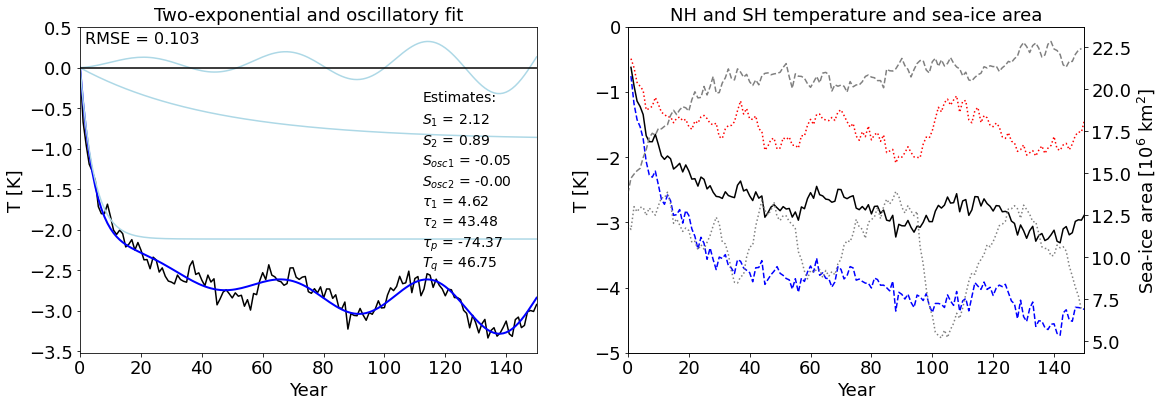

In [106]:
fig, axes = plt.subplots(ncols = 2, figsize = [18,6])

for axis in axes:
    axis.set_xlabel('Year',fontsize = 18)
    axis.set_ylabel('T [K]',fontsize = 18)
    axis.set_xlim(min(years0),max(years0))
    axis.tick_params(axis='both',labelsize=18)
    
ax1 = axes[0]
ax1.plot(years0, deltaT0, color = 'black')
ax1.plot(years0, -model_result.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
# plot components
ax1.plot(years0, -exp_model1.eval(model_result.params, t=years0), color = 'lightblue')
ax1.plot(years0, -exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
ax1.plot(years0, -osc_model.eval(model_result.params, t=years0), color = 'lightblue')
ax1.axhline(y=0, color = 'black')
ax1.set_title('Two-exponential and oscillatory fit', fontsize = 18)
partoshow = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', r'$T_q$']
        
estimates = [model_result.best_values[par] for par in partoshow]
ax1.text(0.01, 0.95, 'RMSE = ' + str(np.round(model_rmse,3)), transform=ax1.transAxes, fontsize = 16)
ax1.text(0.75,0.77, 'Estimates:', fontsize=14, transform=ax1.transAxes)
for (ind, estimate) in enumerate(estimates):
    ax1.text(0.75,0.5*(1.4-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=ax1.transAxes)
    
    
    
ax2 = axes[1]; ax2si = ax2.twinx()
ax2.set_ylim(-5, 0)
ax2.plot(years, tas_Glob, color = 'black')
ax2.plot(years, tas_NH, '--', color = 'blue')
ax2.plot(years, tas_SH, ':', color = 'red')
ax2.set_title('NH and SH temperature and sea-ice area',fontsize = 18)
ax2si.plot(np.array(si_NH_annual)*10**(-12), '--', color = 'gray') # use a factor 10^6 to convert from m^2 to km^2, then divide out another factor 10^6 and put this in ylabel instead
ax2si.plot(np.array(si_SH_annual)*10**(-12), ':', color = 'gray')
ax2si.tick_params(axis='both',labelsize=18)
ax2si.set_ylabel('Sea-ice area [$10^6$ km$^2$]',fontsize = 18);


#plt.savefig('../Figures/' + model + '_' + exp + '_results.pdf', format='pdf', dpi=600, bbox_inches="tight") 